In [334]:
%reload_ext autoreload

In [335]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp
#!pip install wandb

In [336]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean

from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

import wandb

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
sys.path.append('../lib')
import utils
import preprocessing

In [338]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

drop_columns = ['url', 'golive_date']

df_raw = df_raw.drop(columns=drop_columns)

In [339]:
print(len(df_raw), df_raw.shape)

df_processed = preprocessing.prepare_data(df_raw.loc[(df_raw.licence_status != "STAGING") & (df_raw.licence_status != "PARTNER") & (df_raw.plan != "CUSTOM") & (df_raw.plan != "TRIAL")])
df_processed = df_processed.drop(columns=['licence_status'])

print(len(df_processed), df_processed.shape)

6497 (6497, 33)
Sorting dataframe by licence_registration_date ...
Defaulting 'last_login_days' for missing values to the plans mean or platform medeian ...
  Platform 'last_login_days' median: 12.0
  Platform 'last_login_days' mean: 17.269198312236288
  List records that still have NaN in them for feature 'last_login_days' ...
  0
Defaulting 'last_month_total' for missing values to the plans mean or platform medeian ...
  Platform 'last_month_total' median: 0.0
  Platform 'last_month_total' mean: 1.5262305699481866


../lib/preprocessing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:
../lib/preprocessing.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue = mean


  List records that still have NaN in them for feature 'last_month_total' ...
  0
Defaulting 'mtd_total' for missing values to the plans mean or platform medeian ...
  Platform 'mtd_total' median: 0.0
  Platform 'mtd_total' mean: 0.234779792746114
  List records that still have NaN in them for feature 'mtd_total' ...
  0
Defaulting 'last_month_open' for missing values to the plans mean or platform medeian ...
  Platform 'last_month_open' median: 0.0
  Platform 'last_month_open' mean: 0.21275906735751296
  List records that still have NaN in them for feature 'last_month_open' ...
  0
Defaulting 'mtd_open' for missing values to the plans mean or platform medeian ...
  Platform 'mtd_open' median: 0.0
  Platform 'mtd_open' mean: 0.10006476683937823
  List records that still have NaN in them for feature 'mtd_open' ...
  0
Defaulting 'last_month_closed' for missing values to the plans mean or platform medeian ...
  Platform 'last_month_closed' median: 0.0
  Platform 'last_month_closed' mean:

../lib/preprocessing.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature][i] = random_replace_value(df, feature)


Bin days_active ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
One-hot encoding last_login_categories
One-hot encoding days_active
Preprocessing dates ...
Dropping feature account_status ...
Dropping feature customer_account_status_Good ...
Dropping feature canceldate ...
Dropping feature total_churn_concern_cases_age ...
Dropping features with 'interactions' in their name ...
Dropping features with 'churn_concern' in their name ...
Convert categorical features into numbers ...
List any features that still have NaN values ...
Feature has NaN values: golive_days, 2710
Feature has NaN values: licence_registration_Year, 117
Feature has NaN values: licence_registration_Month, 117
Feature has NaN values: licence_registration_Week, 117
Feature has NaN values: licence_registration_Day, 117
Feature has NaN values: licence_registration_Dayofweek, 117
Feature has NaN values: licence_registration_Dayofyear, 117
5907 (5907, 100)


In [340]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5907 entries, 513 to 6491
Data columns (total 100 columns):
username                                 5907 non-null category
last_login_days                          5907 non-null float64
golive_days                              3197 non-null float64
last_month_total                         5907 non-null float64
mtd_total                                5907 non-null float64
last_month_open                          5907 non-null float64
mtd_open                                 5907 non-null float64
last_month_closed                        5907 non-null float64
mtd_closed                               5907 non-null float64
last_month_age_hours                     5907 non-null float64
mtd_age_hours                            5907 non-null float64
month_total_avg                          5907 non-null float64
open_month_avg                           5907 non-null float64
closed_month_avg                         5907 non-null float64
age_hou

In [341]:
df_trn, y_trn, nas = proc_df(df_processed, 'churned')
print(len(df_trn))
print(df_trn.shape)
print(nas)

# take the output of nas, save it in training and use the same values in inference code

5907
(5907, 106)
{'golive_days': 65.0, 'licence_registration_Year': 2016.0, 'licence_registration_Month': 7.0, 'licence_registration_Week': 28.0, 'licence_registration_Day': 18.0, 'licence_registration_Dayofweek': 2.0, 'licence_registration_Dayofyear': 194.0}


In [342]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 1000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

# save the validation data and use in inference notebook

In [370]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((4907, 106), (4907,), (1000, 106), (1000,))

In [344]:
# Fix the dataset imbalance

#sm = SMOTE(random_state=12, ratio = 1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [345]:
#X_train_res.shape, y_train_res.shape

In [346]:
X_train.shape, y_train.shape

((4907, 106), (4907,))

In [347]:
!wandb login dda97ba4df7f598b91affe3c806891df2e043ed7

wandb: Appending key for api.wandb.ai to your netrc file: /Users/justinhennessy/.netrc
Successfully logged in to Weights & Biases!


In [368]:
print("Original array:")
print(y_train)
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Original array:
[0 1 0 ... 0 0 0]
Frequency of unique values of the said array:
[[   0    1]
 [1823 3084]]


In [369]:
print("Original array:")
print(y_valid)
unique_elements, counts_elements = np.unique(y_valid, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Original array:
[0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1
 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0
 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1
 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1
 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0
 1 

In [352]:
import time
seconds = time.time()

run_name = f"customer_churn-{int(seconds)}"
print(run_name)

wandb.init(project="neto-customer-churn", name=f"customer_churn-{int(seconds)}")

columns = df_raw.columns
n_estimators = 2000
min_samples_leaf = 3
max_features = 'sqrt'
n_jobs = -1
max_depth = 2
bootstrap = False
criterion = 'entropy'
class_weight = {0: 3, 1: 1}


m = RandomForestClassifier(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf, 
    max_features=max_features,
    n_jobs=n_jobs,
    max_depth=max_depth,
    bootstrap=bootstrap,
    criterion=criterion,
    class_weight=class_weight
    )

%time m.fit(X_train, y_train)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)

wandb.config.columns = columns
wandb.config.n_estimators = n_estimators
wandb.config.min_samples_leaf = min_samples_leaf
wandb.config.max_features = max_features
wandb.config.n_jobs = n_jobs
wandb.config.max_depth = max_depth
wandb.config.bootstrap = bootstrap
wandb.config.criterion = criterion
wandb.config.class_weight = class_weight

wandb.log({'accuracy': accuracy_score(y_valid,y_pred),
           'precision': precision_score(y_valid,y_pred),
           'recall': recall_score(y_valid,y_pred),
           'cohen_kappa': cohen_kappa_score(y_valid,y_pred),
           'mean_abs_error': mean_absolute_error(y_valid,y_pred),
           'f1_score': f1_score(y_valid,y_pred)})

# you can create this file config-defaults.yaml
# sample config defaults file
#n_estimators:
#  desc: number of estimators in the forest
#  value: 2000

print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "./wandb/churn_model.pkl"
joblib.dump(m, joblib_file)

wandb.save("churn_model.pkl")

customer_churn-1573337820


wandb: Wandb version 0.8.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


CPU times: user 3.15 s, sys: 277 ms, total: 3.43 s
Wall time: 1.68 s
Precision: 0.8637602179836512
Recall: 0.7220956719817767
f1_score: 0.7866004962779155
Accuracy: 0.828
kappa: 0.6444620835348738
mean abs error: 0.172
None
tp, fn, fp, tn
[[511  50]
 [122 317]]


[]

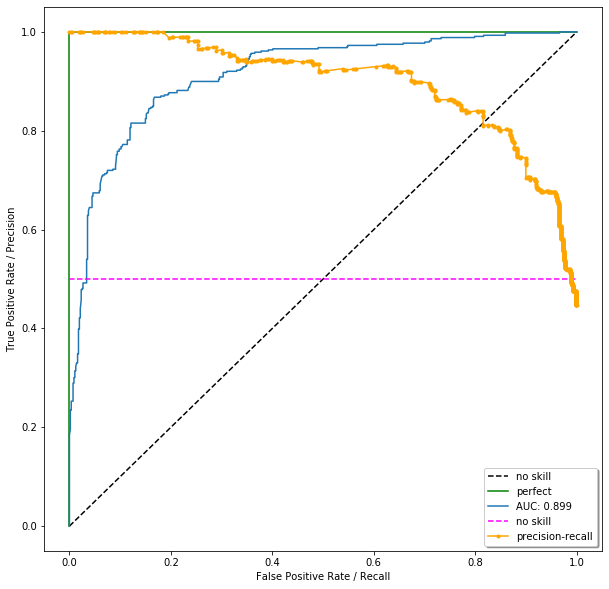

auc=0.899 ap=0.899


In [371]:
utils.plot_roc_pr(m, X_valid, y_valid)
#df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

In [372]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
11,month_total_avg,0.126857
3,last_month_total,0.110371
14,age_hours_month_avg,0.103375
9,last_month_age_hours,0.085420
12,open_month_avg,0.053965
47,plan_PLAN-S-19Q1,0.049639
13,closed_month_avg,0.048133
55,plan_STANDARD,0.038453
99,golive_days_na,0.035905
85,days_active_2years+,0.034534


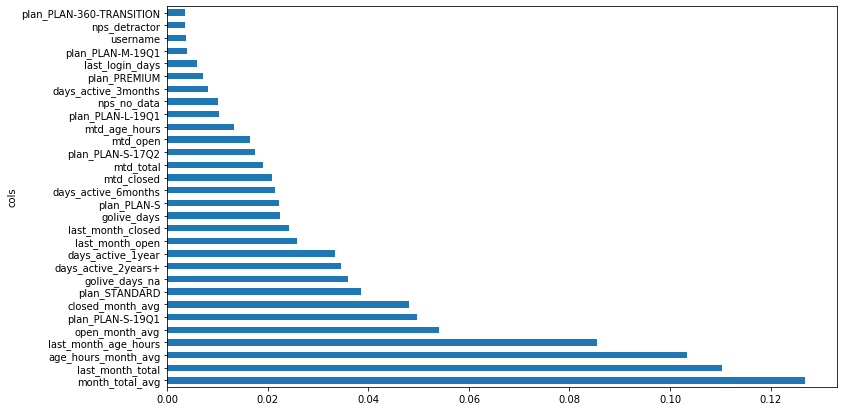

In [373]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [50]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [51]:
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 2, 1: 1},
                       criterion='entropy', max_depth=2, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

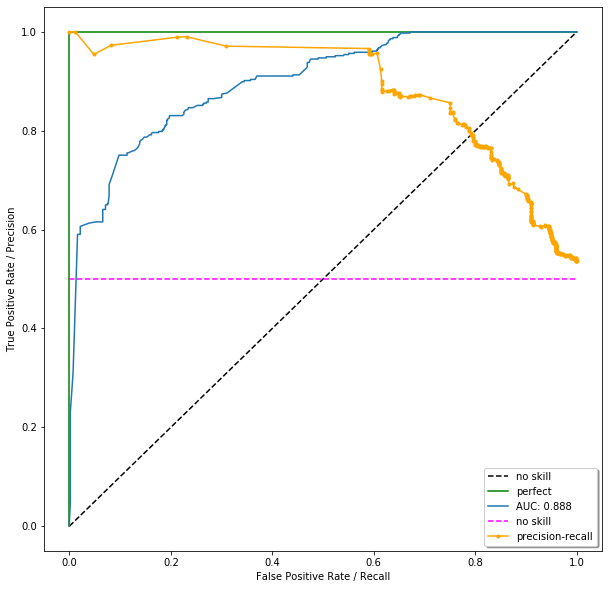

auc=0.888 ap=0.886


In [52]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [22]:
# Save to file in the current working directory
#joblib_file = "churn_model.pkl"
#joblib.dump(m, joblib_file)

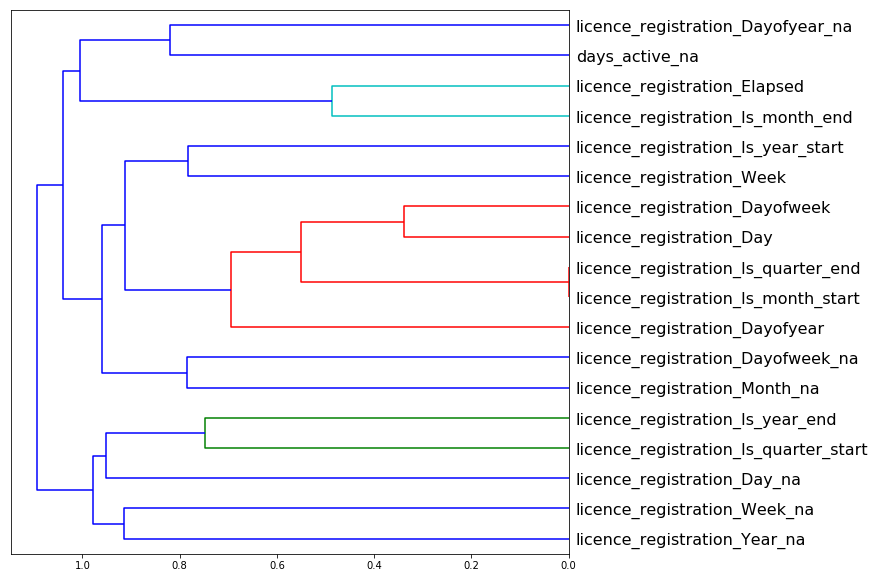

In [23]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [209]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9896995708154507 0.7795807978363759 0.8721633888048411 0.8660590449772142 0.735608778995085 0.1339409550227858
days_active None
0.9968253968253968 0.7430696416497633 0.8514429595196591 0.84802853180107 0.702521755174738 0.15197146819893007
cases_closed None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
cases_total None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
annual_revenue None
0.9967166979362101 0.7183908045977011 0.8349705304518664 0.8335644937586685 0.675789469176262 0.1664355062413315
cases_age_hours_total None
0.9950383400992332 0.7457741717376606 0.8525603864734299 0.8488210818307905 0.7038358069819595 0.15117891816920942
cases_open None
0.9957845433255269 0.7187288708586883 0.8348713921068133 0.8333663562512383 0.6753387771842287 0.16663364374876163
plan_PLAN-S-19Q1